# Yield curves
This notebook constructs and visualizes current and historical US Treasury Yield curves for maturities up to 30 Years. I use cubic splines to interpolate the curve, conviniently provided by SciPy's [InterpolatedUnivariateSpline class](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.InterpolatedUnivariateSpline.html). 

For more details on cubic spining please refer to [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf).

In [1]:
import pandas as pd
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
import matplotlib.ticker as mtick

from dateutil.relativedelta import relativedelta
from datetime import date

from pricing import curves

In [2]:
report_start = date.fromisoformat('2012-01-01')
report_end = date.today()

### Get US Treasury Yields
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `DFF` &mdash; Federal Funds Effective Rate (daily frequency, from 1954)
* `DGS1MO` &mdash; Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS3MO` &mdash; Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS6MO` &mdash; Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS1` &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS2` &mdash; Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS3` &mdash; Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS5` &mdash; Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS7` &mdash; Market Yield on U.S. Treasury Securities at 7-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS20` &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS30` &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)

In [3]:
data = web.get_data_fred(['DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'], report_start, report_end)
data.dropna(inplace=True)

date = data.index[-1].date()
date_1_year_ago = date + relativedelta(years=-1)
date_2_years_ago = date + relativedelta(years=-2)
date_5_years_ago = date + relativedelta(years=-5)
date_10_years_ago = date + relativedelta(years=-10)

offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20), relativedelta(years=+30)]

# Define yield curves
curve = curves.YieldCurve(date, offsets, data[date:date+BDay()].to_numpy()[0,:])
curve_1_year_ago = curves.YieldCurve(date_1_year_ago, offsets,
                                     data[date_1_year_ago:date_1_year_ago+BDay()].to_numpy()[0,:])
curve_2_years_ago = curves.YieldCurve(date_2_years_ago, offsets,
                                      data[date_2_years_ago:date_2_years_ago+BDay()].to_numpy()[0,:])
curve_5_years_ago = curves.YieldCurve(date_5_years_ago, offsets,
                                      data[date_5_years_ago:date_5_years_ago+BDay()].to_numpy()[0,:])
curve_10_years_ago = curves.YieldCurve(date_10_years_ago, offsets,
                                       data[date_10_years_ago:date_10_years_ago+BDay()].to_numpy()[0,:])

### Constructing curve points for today's treasury curve

In [4]:
curve_points = curve.get_curve_points(120)

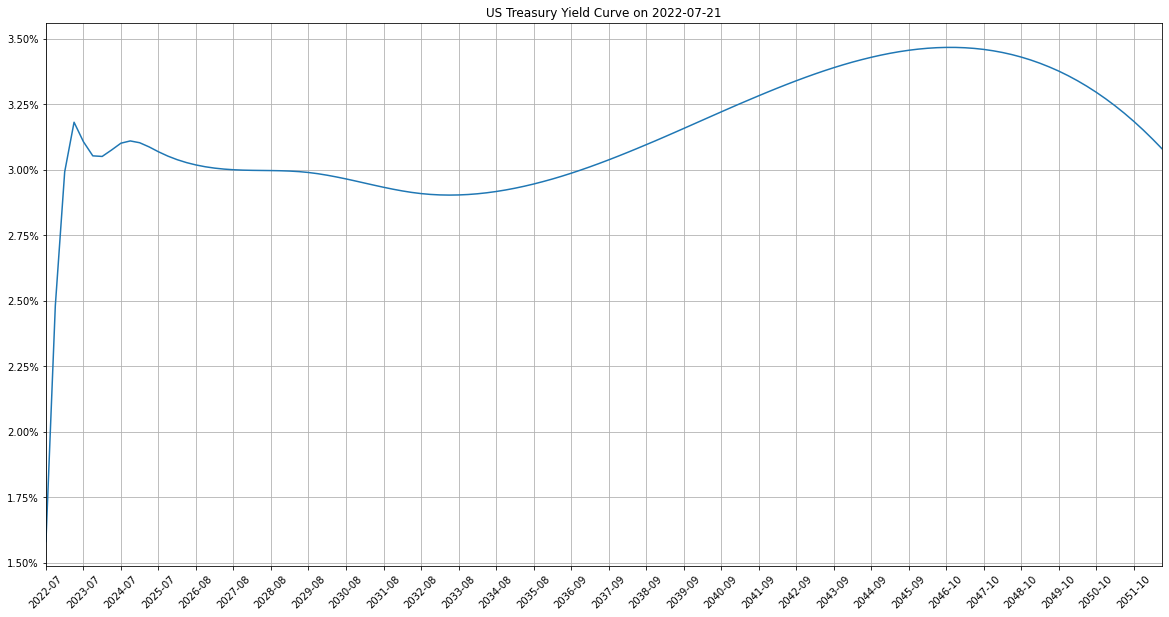

In [5]:
ax = curve_points.plot(figsize=(20,10), grid=True, title='US Treasury Yield Curve on ' + date.strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))

### Constructing curves points indexed by relative maturities

In [6]:
# Construct curve points indexed by maturities
curve_points = curve.get_curve_points_indexed_by_maturities(120, maturity_repr=curves.MaturityRepresentation.YEARS)
curve_points_1_year_ago = curve_1_year_ago.get_curve_points_indexed_by_maturities(120)
curve_points_2_years_ago = curve_2_years_ago.get_curve_points_indexed_by_maturities(120)
curve_points_5_years_ago = curve_5_years_ago.get_curve_points_indexed_by_maturities(120)
curve_points_10_years_ago = curve_10_years_ago.get_curve_points_indexed_by_maturities(120)

# Ensure they have the same index, a difference of +- 1-2 business days max
curve_points_1_year_ago = curve_points_1_year_ago.set_axis(curve_points.index)
curve_points_2_years_ago = curve_points_2_years_ago.set_axis(curve_points.index)
curve_points_5_years_ago = curve_points_5_years_ago.set_axis(curve_points.index)
curve_points_10_years_ago = curve_points_10_years_ago.set_axis(curve_points.index)

df = pd.DataFrame([curve_points_10_years_ago, curve_points_5_years_ago, curve_points_2_years_ago,
                   curve_points_1_year_ago, curve_points]).transpose()

In [7]:
df

,2012-07-23,2017-07-21,2020-07-21,2021-07-21,2022-07-21
0.000000,0.140000,1.160000,0.100000,0.100000,1.580000
0.251894,0.101012,1.155239,0.130041,0.050030,2.480363
0.503788,0.140369,1.101122,0.129977,0.049981,2.991454
0.755681,0.155991,1.100941,0.133473,0.051095,3.181034
1.007575,0.170651,1.221694,0.150491,0.070928,3.106718
...,...,...,...,...,...
28.995163,2.432449,2.783380,1.316784,1.971698,3.215263
29.247057,2.452623,2.789918,1.315874,1.964754,3.184576
29.498950,2.473915,2.796531,1.314446,1.957162,3.151833
29.750844,2.496362,2.803224,1.312492,1.948914,3.116989


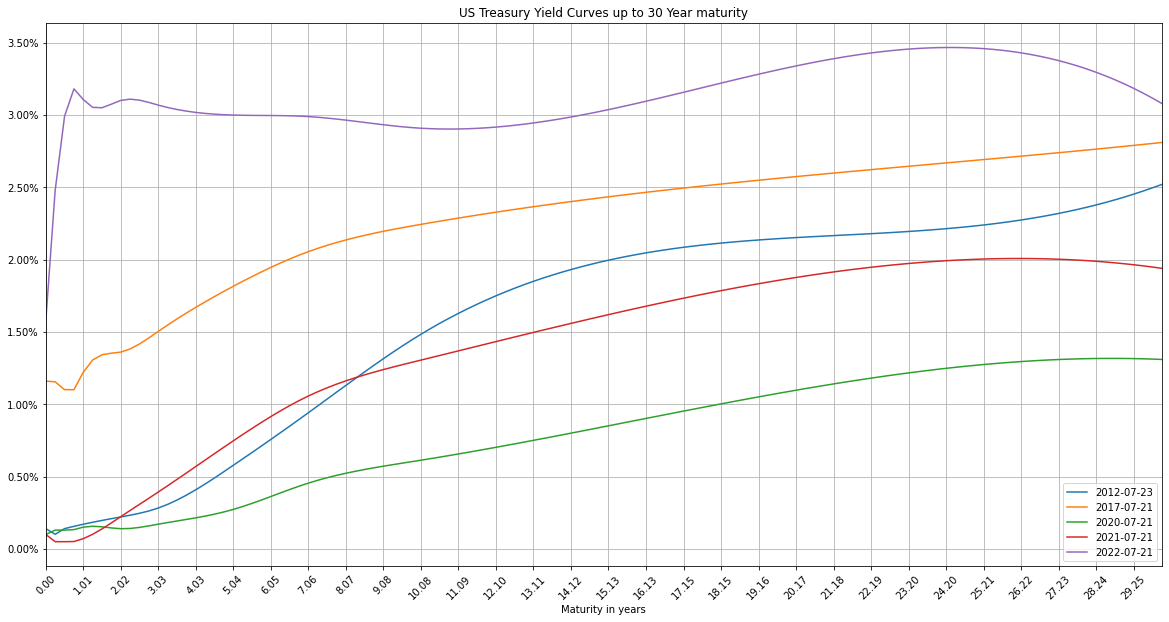

In [8]:
ax = df.plot(figsize=(20,10), grid=True, title='US Treasury Yield Curves up to 30 Year maturity',
             xlim=(curve_points.index[0], curve_points.index[-1]),
             xticks=curve_points.index[::4], xlabel='Maturity in years', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

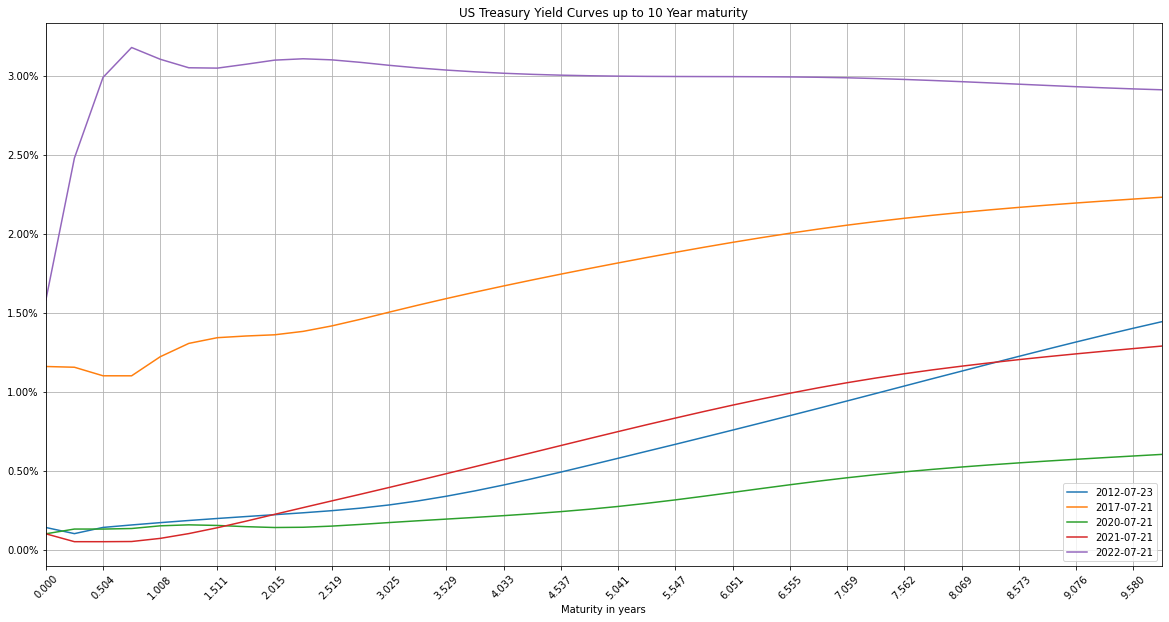

In [9]:
df_10_years = df.iloc[:40]
ax = df_10_years.plot(figsize=(20,10), grid=True, title='US Treasury Yield Curves up to 10 Year maturity',
             xlim=(df_10_years.index[0], df_10_years.index[-1]),
             xticks=df_10_years.index[::2], xlabel='Maturity in years', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())